# Measure 4: Social Network Analysis (The "Hub" & The "Isolate")

## 1. Introduction & Objective
**Objective:** To visualize the social structure of *Anna Karenina* and quantify character interactions using Network Theory metrics.

**Theoretical Framework:**
Leo Tolstoy constructs the novel around two parallel plots that rarely intersect. This analysis aims to prove this structural separation quantitatively:
1.  **The Society Plot (Anna):** A dense, interconnected web of St. Petersburg/Moscow society.
2.  **The Rural Plot (Levin):** An isolated, philosophical narrative largely removed from the main social centers.

## 2. Methodology
We utilize a **weighted undirected graph** where:
* **Nodes (Characters):** Sized by **Degree Centrality** (popularity) and colored by a **Heatmap** (Yellow = Highly Connected, Purple = Isolated).
* **Edges (Lines):** Represent co-occurrence in the same sentence. Line thickness represents the frequency of interaction.
* **Layout:** A force-directed algorithm (`spring_layout`) simulates social clusters naturally.

In [22]:
# Install dependencies (Run once)
%pip install networkx pandas matplotlib nltk

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import display

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('punkt_tab')

# --- PATH CONFIGURATION ---
DATA_DIR = '../data'
RESULTS_DIR = '../results'

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# --- TARGET CONFIGURATION ---
# Filtering for the 8 primary characters to maintain graph readability
CONFIG = {
    "filename": "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt",
    # Dictionary format: "Standard Name": ["List", "Of", "Aliases"]
    "characters": {
        "Anna": ["Anna", "Arkadyevna", "Karenina"],
        "Vronsky": ["Vronsky", "Alexey Kirillovitch", "Count Vronsky"], 
        # Note: Excluded plain "Alexey" because it is also Karenin's first name
        "Levin": ["Levin", "Konstantin", "Dmitrievitch"],
        "Kitty": ["Kitty", "Ekaterina", "Scherbatskaya"],
        "Karenin": ["Karenin", "Alexey Alexandrovitch"], 
        "Stiva": ["Stiva", "Stepan", "Arkadyevitch", "Oblonsky"],
        "Dolly": ["Dolly", "Darya", "Alexandrovna"],
        "Betsy": ["Betsy", "Tverskaya"]
    }
}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 3. Data Processing Pipeline

The following functions handle the text processing:
1.  **Sentence Segmentation:** Splitting the raw text into distinct sentences.
2.  **Interaction Scanning:** Identifying which characters appear together in a sentence.
3.  **Graph Construction:** Building the mathematical model of connections.

In [24]:
def build_graph(text, char_dict):
    """
    Builds a weighted undirected graph using a dictionary of aliases.
    
    Args:
        text (str): The full text of the novel.
        char_dict (dict): Format {"MainName": ["alias1", "alias2"]}
    """
    sentences = sent_tokenize(text)
    G = nx.Graph()
    
    # Add nodes for the main character names (keys of the dictionary)
    G.add_nodes_from(char_dict.keys())
    
    # --- STEP 1: Create a Lookup Map ---
    # We flatten the dictionary so we can instantly look up any alias.
    # Example: lookup_map['arkadyevna'] = 'Anna'
    lookup_map = {}
    for main_name, aliases in char_dict.items():
        for alias in aliases:
            # We split multi-word aliases (e.g. "Alexey Alexandrovitch") 
            # so we catch them even if they are tokenized separately.
            parts = alias.lower().split()
            for part in parts:
                lookup_map[part] = main_name

    print(f"Processing {len(sentences)} sentences with Alias Matching...")
    
    # --- STEP 2: Scan Sentences ---
    for sent in sentences:
        tokens = set(word_tokenize(sent.lower()))
        found = set()
        
        # Check every word in the sentence against our alias map
        for token in tokens:
            if token in lookup_map:
                found.add(lookup_map[token])
        
        # --- STEP 3: Create Edges ---
        # If 2 or more characters are found in this sentence, link them.
        if len(found) > 1:
            for pair in itertools.combinations(found, 2):
                u, v = pair
                if G.has_edge(u, v):
                    G[u][v]['weight'] += 1
                else:
                    G.add_edge(u, v, weight=1)
    
    return G

## 4. Visualization Engine

This section generates the final high-resolution visualization.

**Visual Features:**
* **Force-Directed Layout:** Simulates physical forces to cluster related characters.
* **Heatmap Coloring:** Nodes range from Yellow (High Centrality) to Purple (Low Centrality).
* **Embedded Legend:** A numbered list in the bottom-right corner provides immediate context.
* **Source Credit:** Citation included in the bottom-left.

In [25]:
def analyze_and_draw(G):
    # --- 1. FILTER NOISE ---
    THRESHOLD = 5
    to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < THRESHOLD]
    G.remove_edges_from(to_remove)
    print(f"Removed {len(to_remove)} weak connections (weight < {THRESHOLD}).")

    # --- SETUP PLOT ---
    plt.figure(figsize=(15, 12), facecolor='white') # Made figure slightly larger
    ax = plt.gca()
    
    # --- 2. PHYSICS LAYOUT ---
    pos = nx.spring_layout(G, k=0.7, weight='weight', iterations=50, seed=42) 
    
    # --- 3. CALCULATE METRICS ---
    weighted_degrees = dict(G.degree(weight='weight'))
    
    # INCREASED NODE SIZE: Multiplier 2->8, Base 300->1500
    node_sizes = [weighted_degrees[n] * 8 + 1500 for n in G.nodes()]
    
    # Calculate edge thickness
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    
    # --- DRAW EDGES ---
    for (u, v, d) in G.edges(data=True):
        width = (d['weight'] / max_weight) * 8 + 0.5 # Slightly thicker lines too
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.4, 
                               edge_color="#555555", connectionstyle="arc3,rad=0.1", 
                               arrows=True, arrowstyle="-", ax=ax)

    # --- DRAW NODES ---
    node_colors = [weighted_degrees[n] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                           cmap=plt.cm.plasma, alpha=0.9, edgecolors='white', linewidths=3, ax=ax)
    
    # --- DRAW LABELS (BIGGER FONT) ---
    # Font size increased 11 -> 14
    labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")
    import matplotlib.patheffects as path_effects
    for _, label in labels.items():
        label.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])

    # --- ADD LEGEND (BIGGER FONT) ---
    sorted_stats = sorted(weighted_degrees.items(), key=lambda item: item[1], reverse=True)
    
    legend_text = "Interaction Volume\n(Weighted Degree)\n" + "-"*20 + "\n"
    for i, (char, count) in enumerate(sorted_stats, 1):
        legend_text += f"{i}. {char:<10} : {int(count)}\n"

    props = dict(boxstyle='round', facecolor='white', alpha=0.95, edgecolor='gray')
    
    # Legend font size 11 -> 13
    plt.text(0.96, 0.02, legend_text.strip(), transform=ax.transAxes, fontsize=13,
             verticalalignment='bottom', horizontalalignment='right', bbox=props, fontfamily='monospace')

    # --- TITLES & SAVING ---
    plt.title("Character Interaction Network: Anna Karenina", fontsize=22, fontweight='bold', pad=20)
    plt.axis('off')
    
    save_path = f"{RESULTS_DIR}/anna_karenina_network_refined.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Graph saved to: {save_path}")

    # --- DISPLAY FULL TABLE BELOW ---
    print("\n" + "="*40)
    print("WEIGHTED CONNECTION DATA TABLE")
    print("="*40)
    
    df = pd.DataFrame(sorted_stats, columns=['Character', 'Interaction Volume'])
    df.index += 1 
    
    display(df)
    
    csv_path = f"{RESULTS_DIR}/anna_karenina_network_table.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nTable saved to: {csv_path}")

## 5. Main Execution
Run this cell to load the data, generate the visual, and export the statistics.

Loading text data...
Processing 16927 sentences with Alias Matching...
Generating network visualization and data table...
Removed 1 weak connections (weight < 5).


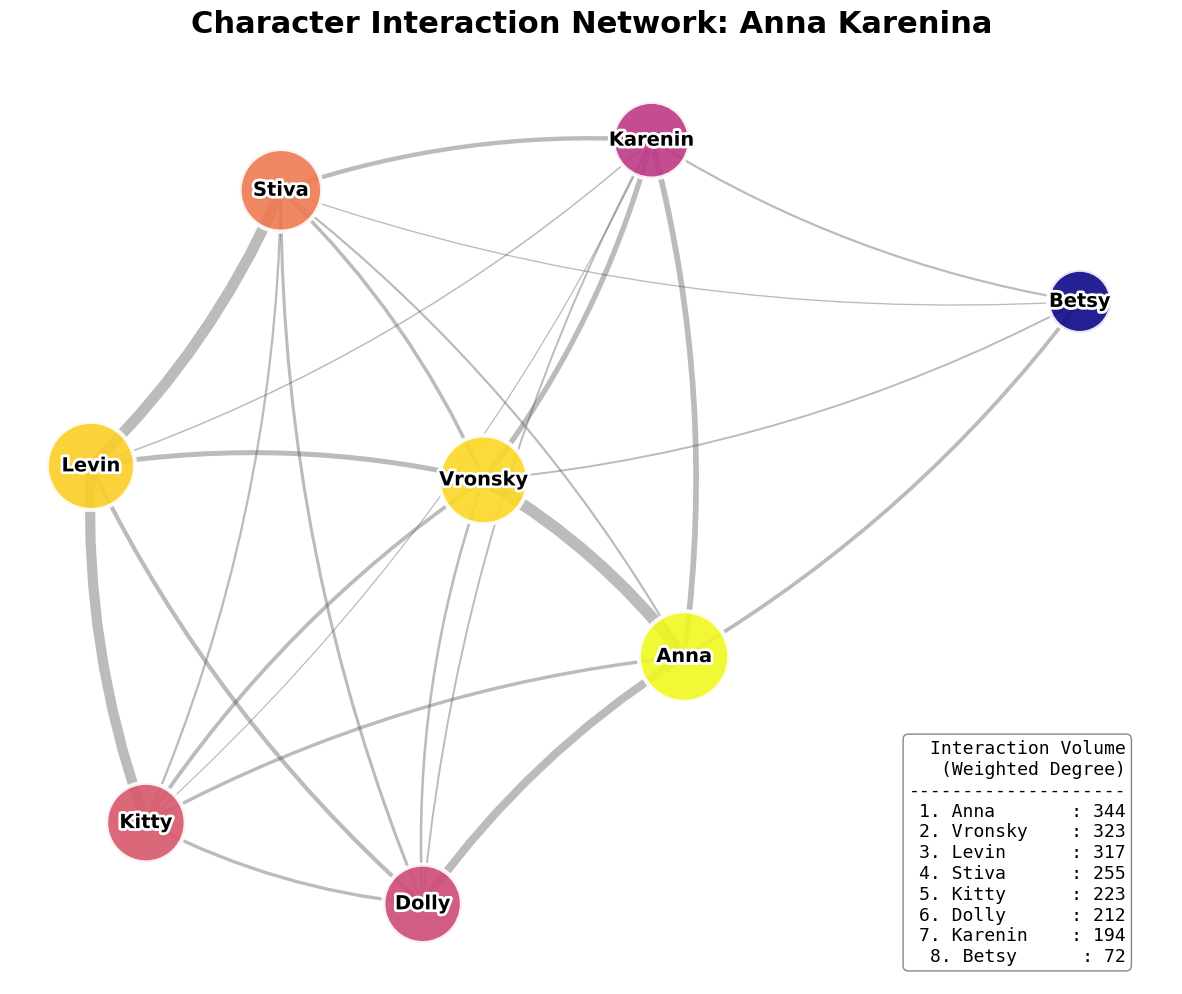

Graph saved to: ../results/anna_karenina_network_refined.png

WEIGHTED CONNECTION DATA TABLE


,Character,Interaction Volume
1,Anna,344
2,Vronsky,323
3,Levin,317
4,Stiva,255
5,Kitty,223
6,Dolly,212
7,Karenin,194
8,Betsy,72



Table saved to: ../results/anna_karenina_network_table.csv


In [26]:
# --- 1. DEFINE THE MISSING FUNCTION ---
def load_text(filename):
    filepath = os.path.join(DATA_DIR, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"ERROR: Could not find file {filepath}")
        return ""

# --- 2. RUN THE ANALYSIS ---
def run_analysis():
    print("Loading text data...")
    # Now load_text is defined and will work
    text = load_text(CONFIG['filename'])
    
    if text:
        G = build_graph(text, CONFIG['characters'])
        if G.number_of_edges() > 0:
            print("Generating network visualization and data table...")
            analyze_and_draw(G)
        else:
            print("No interactions found among the specified characters.")
    else:
        print("File not found. Please check DATA_DIR path.")

run_analysis()

## 6. Interpretation of Results

### Reading the Graph
1.  **The Hub (Anna):** 
    * **Color:** Bright Yellow (High Heatmap score).
    * **Role:** She is the structural center, connecting her husband (Karenin), her lover (Vronsky), and the socialite circle (Betsy).
    
2.  **The Isolate (Levin):** 
    * **Color:** Orange/Purple (Lower Heatmap score).
    * **Role:** Pushed to the periphery by the layout algorithm. He lacks direct connections to the antagonist figures (Karenin/Vronsky), visually confirming his isolation from the main society plot.

3.  **The Bridge (Stiva):** 
    * Stiva Oblonsky acts as the crucial connector between the two storylines (Anna's vs. Levin's).